In this notebook, I use Latent Semantic Analysis (LSA) to cluster the story data and examine possible story groupings.

In [1]:
import pandas as pd
import scipy.sparse as ss
import matplotlib.pyplot as plt

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim import matutils, models
from gensim.models.coherencemodel import CoherenceModel
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score

In [2]:
stories = pd.read_pickle('files/corpus.pkl')

First, the data need to be organized in a parsable form. A common way of doing this is to organize the data into a document-term matrix using a TF-IDF vectorizer. This method identifies word importance across the stories by weighting words based on their frequency and how many documents they appear in.  

In [3]:
# remove common noise words
extras = ['like', 'just', 'said', 'im', 'didnt', 'dont', 'did', 'youre', 'youare', 'werent']
stop_words = text.ENGLISH_STOP_WORDS.union(extras)

In [4]:
vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.8) # upper bound to reduce noise from nonsense terms
X = vectorizer.fit_transform(stories['story'])
X

<3499x62947 sparse matrix of type '<class 'numpy.float64'>'
	with 1833609 stored elements in Compressed Sparse Row format>

In [5]:
# create corpus and term dictionary 
corpus = matutils.Sparse2Corpus(X)
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

Now that the data are in dtm form, they can be analysed using machine learning. The stories can be clustered to reveal similarities based on word frequency. One such clustering method is Latent Semantic Indexing. This procedure involves decomposing the dtm using SVD to create linear combinations of words. These combinations show recurrent patterns in the stories and can be used to cluser them.

The optimal number of combinations to use is explored below using the UMass CoherenceModel, which ranges from -14 (low coherence) to 14 (high coherence).

In [6]:
scores = []

for n in range(2,51):
    lsa = models.LsiModel(corpus, id2word=id2word, num_topics=n, decay=0.5)
    cm = CoherenceModel(model=lsa, corpus=corpus, coherence='u_mass')
    scores.append(cm.get_coherence())

Text(0, 0.5, 'Coherence score')

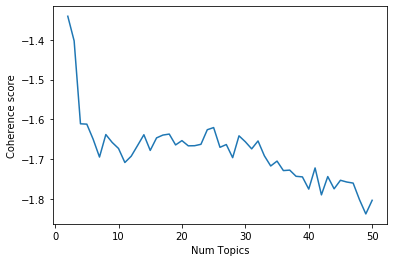

In [7]:
plt.plot(range(2,51), scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

The highest coherence value occurs for 2 clusters. The word combinations in the clusters are printed below.

In [8]:
lsa = models.LsiModel(corpus, id2word=id2word, num_topics=2, decay=0.5, power_iters=10)
lsa.print_topics()

[(0,
  '0.040*"antigoneit" + 0.040*"adrenalin" + 0.039*"amelia" + 0.039*"alisons" + 0.037*"arighty" + 0.037*"andohhh" + 0.036*"andcmon" + 0.036*"accredit" + 0.036*"alley" + 0.036*"agility"'),
 (1,
  '-0.149*"amelia" + -0.147*"ambient" + -0.147*"askew" + -0.138*"aed" + -0.136*"abfout" + -0.132*"aisles" + -0.126*"altimahtei" + 0.125*"archambault" + 0.121*"alseep" + 0.116*"arterial"')]

These clusters aren't very useful, so another method should be used. Another very common clustering technique is k-means. The word frequencies can be used in k-means to cluster stories similar to LSI above.

Since there are several thousand unique words, it helps to reduce the dimensions of the dtm to help initialize k-means and reduce the effect of noise words. SVD is now useful again to lower the number of features while retaining the variance in the story data. 

In [9]:
# dimension reduction using singular values 
svd = TruncatedSVD(n_components=1500)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
topic_matrix = lsa.fit_transform(X)

In [10]:
# retains almost 75% of variance
svd.explained_variance_ratio_.sum()

0.7456406838209589

K-means is now applied to cluster the stories. Once again, a range of cluster numbers is explored, this time by using a silhouette score. This metric shows how similar the word combinations from SVD are to members of their assigned cluser relative to other word combination clusters. 

In [11]:
scores = []

for i in range(2,51):
    mod = KMeans(n_clusters=i).fit(topic_matrix)
    scores.append(silhouette_score(topic_matrix, mod.labels_, sample_size=1000))

Text(0, 0.5, 'Silhouette score')

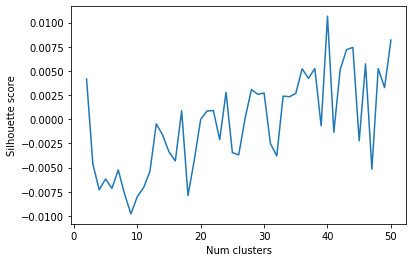

In [12]:
plt.plot(range(2,51), scores)
plt.xlabel("Num clusters")
plt.ylabel("Silhouette score")

In [13]:
# ranges from 2 to 50, so add 2 to get best number
scores.index(max(scores))+2

40

Now, the story clusers can be explored. Some clusters have more members than others, so the variance in these clusers will be lower than those with fewer members.

In [14]:
mod = KMeans(n_clusters=40).fit(topic_matrix)

In [15]:
meta = pd.read_pickle('files/creep.pkl')
meta['cluster'] = mod.labels_

In [16]:
meta.cluster.value_counts()

11    704
28    406
34    330
19    320
18    211
12    171
6     127
16    122
32    108
2      92
37     87
35     79
14     59
13     58
23     52
24     48
30     46
4      40
26     34
3      34
17     26
20     25
39     25
38     25
21     24
33     21
15     20
1      18
22     18
9      18
31     18
7      17
36     16
5      16
27     16
10     15
29     15
25     14
8      14
0      10
Name: cluster, dtype: int64

The mean statistics for the clusters are shown below. 

In [17]:
meta.groupby('cluster').mean().sort_values(['rating'], ascending=False)

,rating,time,polarity,subjectivity,title_length,subgenre_count,num_words,mean_word_freq,num_unique_words,unique_ratio
cluster,,,,,,,,,,
29,8.118000,13.400000,0.017426,0.515624,2.333333,5.000000,1483.200000,0.002236,634.266667,0.518549
10,8.082000,10.466667,0.011368,0.518948,3.000000,4.266667,1188.733333,0.002237,584.466667,0.530178
23,7.975000,9.865385,0.024925,0.510627,3.634615,3.884615,1099.980769,0.003633,505.961538,0.541559
36,7.893125,12.062500,-0.017908,0.496046,3.875000,5.687500,1457.500000,0.002521,642.437500,0.518111
19,7.885375,15.003125,0.029428,0.519492,3.393750,5.003125,2615.568750,0.002063,708.853125,0.530806
24,7.863542,7.104167,0.019256,0.482213,3.520833,4.479167,775.604167,0.003343,418.395833,0.590400
12,7.856316,8.771930,0.013559,0.504793,3.228070,4.403509,930.116959,0.003047,470.099415,0.575003
22,7.852222,9.388889,0.000122,0.508276,3.500000,5.388889,1062.555556,0.002856,539.000000,0.575214
15,7.802500,12.350000,0.022321,0.505770,3.200000,4.900000,1510.950000,0.002923,734.700000,0.552812


We can use the inverse SVD to recover the actual words used in the clusters. 

In [18]:
original_space_centroids = svd.inverse_transform(mod.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [20]:
terms = vectorizer.get_feature_names()

for i in range(40):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: george catherine danny house ryan jerry room jimmy sal head face auburn episode old woman
Cluster 1: bus driver window stop seat hollis night door tommys road street day want passenger ruby
Cluster 2: jason katie husband daniel wife woman son door room house annie old day tell hand
Cluster 3: john anna hand tell ben thing want ask man leave hed felt turn way dad
Cluster 4: noise hear thump window sound sleep room try youve silence bed turn door ear night
Cluster 5: tom ask ya room day steve want little picture man milo home head alex house
Cluster 6: world universe human people ship thing life mind earth create exist day humanity subject body
Cluster 7: nick lisa dani lisas nancy ben door pillow ari watcher tell mr thing start love
Cluster 8: jeremy hank jeremys tracer clark emma alison thing hand train blood id room try mommy
Cluster 9: jake jakes man dad dalton hat saga joe room thing ani lucas jacob hand stop
Cluster 10: matt tony harold christina jon tunnel jimi door jen

Conclusions:

Different names affect clustering 
Subtopics like gaming, ghosts, houses, etc are distinct
Hard to tell which word grouping affect ratin

clusters random; groupings may not be statistically significant
sample size small for clusters